# Single Model Training

This notebook is to enable model training for a single model using the specified parameters in config.yaml.


In [25]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.pipelines.xgboost.train_single_model import main

## 1. Run Model

In [26]:
# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient
from src.core.config_loader import ConfigLoader

bq_client = BigQueryClient()
config_loader = ConfigLoader()

sales_query = f"""
    SELECT 
    *  
    FROM `porygon-pipelines.walmart_training_tables.walmart_master_table` tgt
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND is_stockout_tgt = 0
        AND fea_item_longevity_months >=0
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 110992 rows from custom query.


In [27]:
df[["fea_item_longevity_months", "is_stockout_tgt"]].drop_duplicates()

,fea_item_longevity_months,is_stockout_tgt
0,0,0
77,1,0
173,2,0
261,3,0
357,4,0
...,...,...
6832,56,0
6985,57,0
7147,58,0
7304,59,0


INFO:src.pipelines.xgboost.train_single_model:
        XGBoost Model Training Pipeline is starting...
        
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 148964 rows from table: walmart_master_table
INFO:src.pipelines.xgboost.train_single_model:Filtering outliers ...
INFO:src.pipelines.xgboost.train_single_model:Training model...
INFO:src.core.models.xgboost:
            Training XGBoost Model...
            


[0]	validation_0-rmse:1.56925	validation_1-rmse:1.22120
[1]	validation_0-rmse:1.19547	validation_1-rmse:1.00635
[2]	validation_0-rmse:0.96041	validation_1-rmse:0.88949
[3]	validation_0-rmse:0.82082	validation_1-rmse:0.83037
[4]	validation_0-rmse:0.74284	validation_1-rmse:0.80402
[5]	validation_0-rmse:0.70132	validation_1-rmse:0.79229
[6]	validation_0-rmse:0.67989	validation_1-rmse:0.78805
[7]	validation_0-rmse:0.66904	validation_1-rmse:0.78686
[8]	validation_0-rmse:0.66323	validation_1-rmse:0.78704
[9]	validation_0-rmse:0.66027	validation_1-rmse:0.78794
[10]	validation_0-rmse:0.65869	validation_1-rmse:0.78890
[11]	validation_0-rmse:0.65712	validation_1-rmse:0.78964
[12]	validation_0-rmse:0.65617	validation_1-rmse:0.79024
[13]	validation_0-rmse:0.65559	validation_1-rmse:0.79077
[14]	validation_0-rmse:0.65508	validation_1-rmse:0.79134
[15]	validation_0-rmse:0.65459	validation_1-rmse:0.79181
[16]	validation_0-rmse:0.65395	validation_1-rmse:0.79253
[17]	validation_0-rmse:0.65309	validation

INFO:src.core.models.xgboost:Model saved to /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260124_135421/model_0.joblib
INFO:src.core.models.xgboost:
            Model Training Pipeline completed successfully!
            Run ID: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260124_135421
            Artifacts saved to: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260124_135421
            


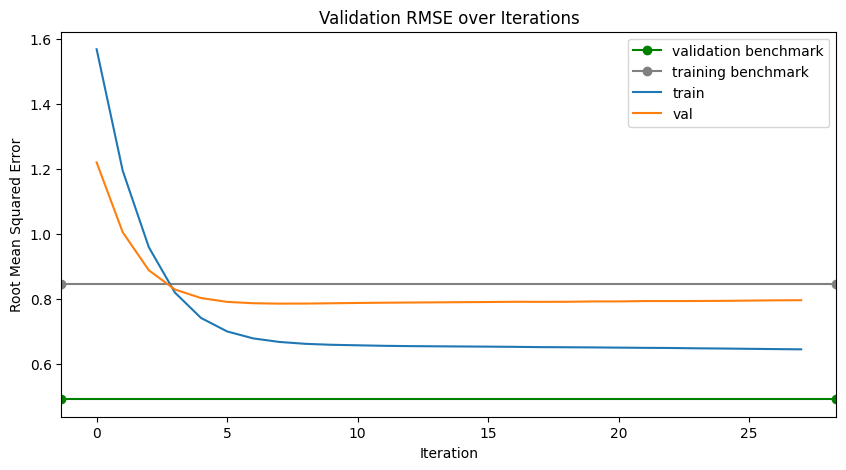

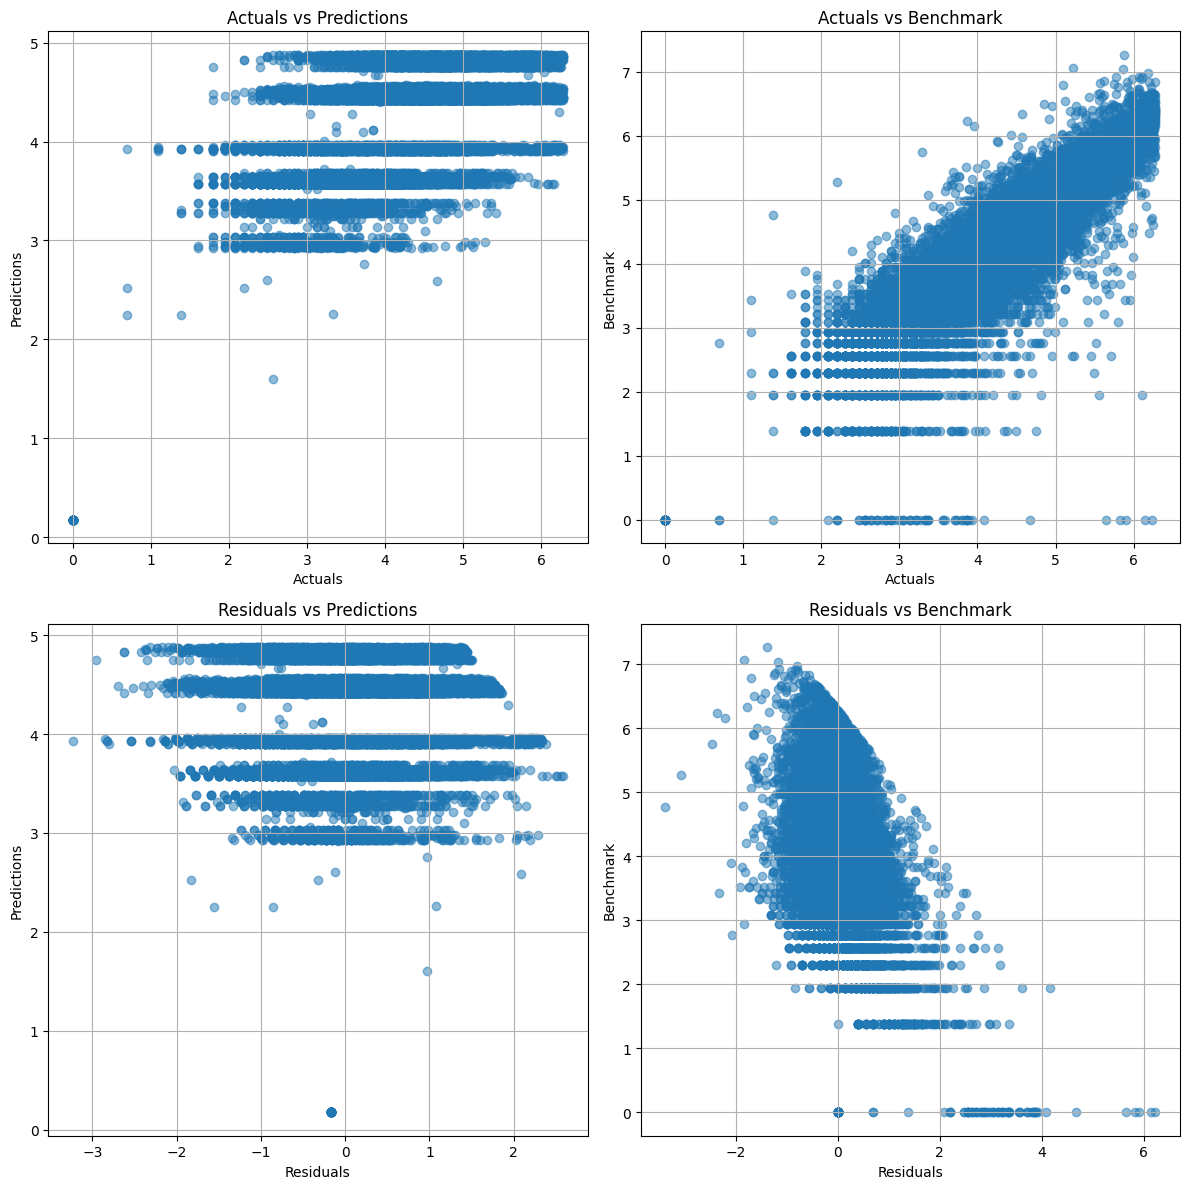

In [28]:
features = [
    c for c in 
    df if "fea_" in c
]
trained_model = main(features = features)

## 2. Compare metrics with Benchmark

1. Compare Metrics (MdAPE, MdAE) with benchmark in total and accross validation sets of interest

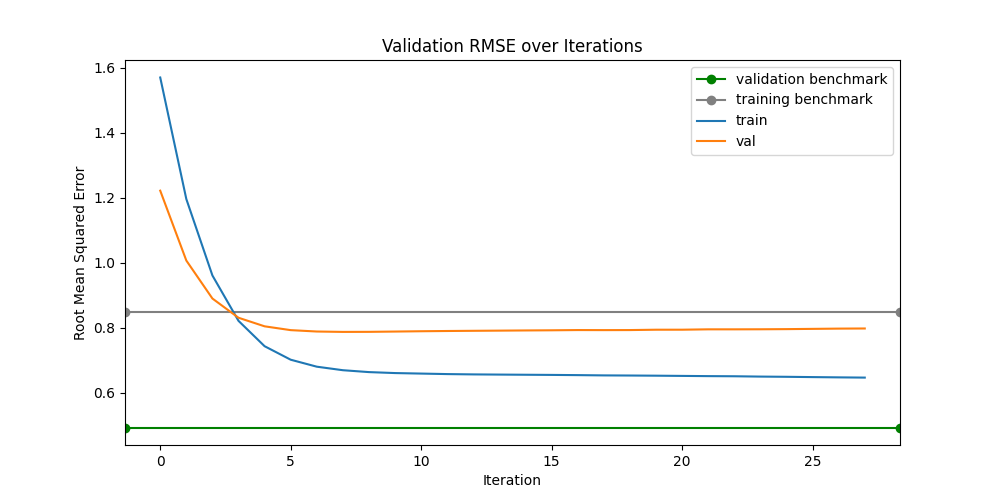

In [29]:
from IPython.display import Image, display
display(Image(trained_model.plot_bias_variance_tradeoff_path))

## 6. Evaluate Residuals

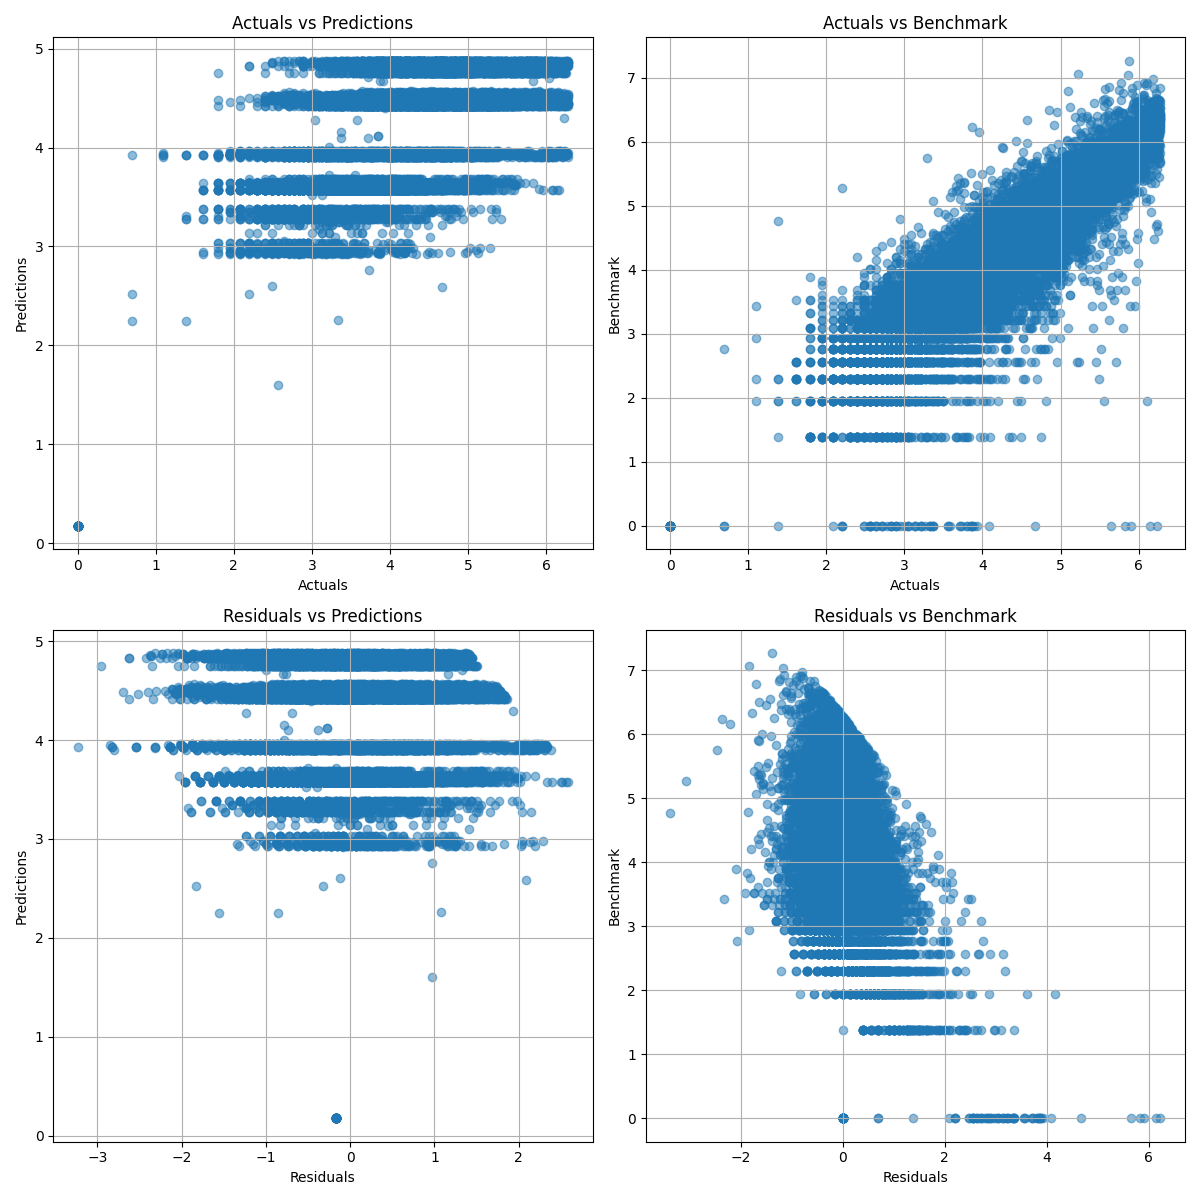

In [30]:
from IPython.display import Image, display
display(Image(trained_model.plot_residuals_paths))

## 8. Feature Importance

In [31]:
trained_model.feature_importance

,feature,importance
9,fea_item_longevity_months,471.0
5,fea_is_event_3m,143.0
3,fea_dept_number,120.0
1,fea_is_hobbies,95.0
4,fea_is_weekend_3m,79.0
8,fea_is_national_event_3m,64.0
7,fea_is_cultural_event_3m,55.0
0,fea_is_foods,34.0
6,fea_is_sporting_event_3m,34.0
2,fea_is_household,30.0


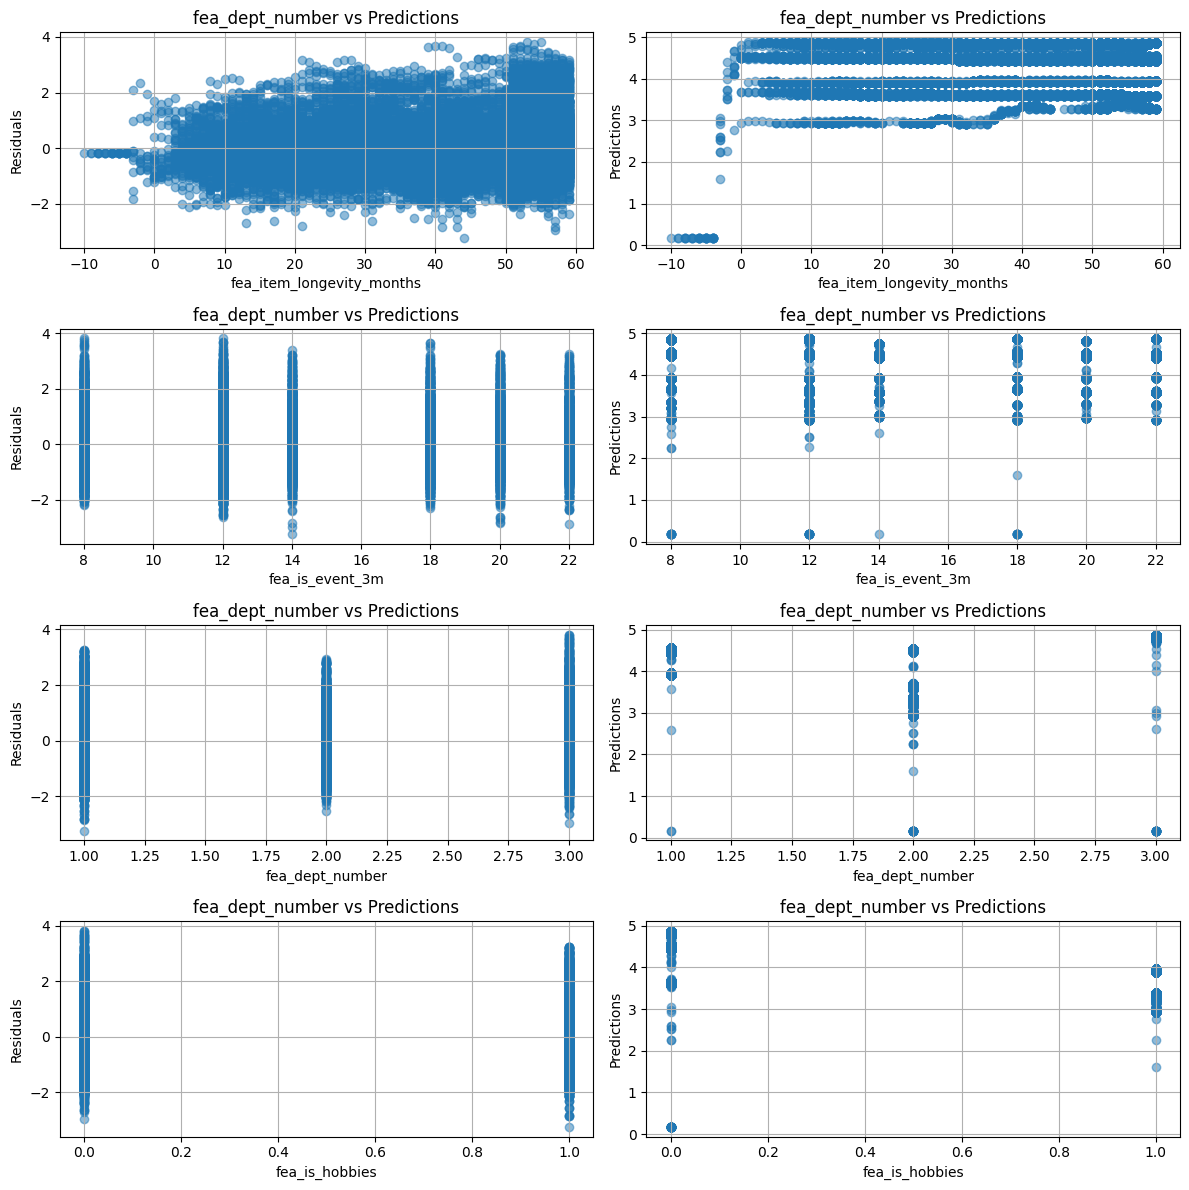

In [32]:
top_importance = trained_model.feature_importance[:4]
fig, axs = plt.subplots(len((top_importance["feature"].to_list())),2, figsize=(12,12))

for ax_index, feature in zip(range(len((top_importance["feature"].to_list()))), trained_model.feature_importance["feature"].to_list()):
    # Feature vs Residual
    axs[ax_index, 0].scatter(validation_df[feature], residuals, alpha = 0.5)
    axs[ax_index, 0].set_xlabel(feature)
    axs[ax_index, 0].set_ylabel("Residuals")
    axs[ax_index, 0].set_title("fea_dept_number vs Predictions")
    axs[ax_index, 0].grid(True)

    # Feature vs Prediction
    axs[ax_index, 1].scatter(validation_df[feature], predictions, alpha = 0.5)
    axs[ax_index, 1].set_xlabel(feature)
    axs[ax_index, 1].set_ylabel("Predictions")
    axs[ax_index, 1].set_title("fea_dept_number vs Predictions")
    axs[ax_index, 1].grid(True)

plt.tight_layout()